import

In [1]:
!pwd

/e/2-2/Cn240/.Project_cancer/4-21-2023/logisticregression


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import statistics
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV

function

In [3]:
# # tn, fp, fn, tp = each_index(cm)
def each_index(metrix):
    TN = metrix[0][0]
    FP = metrix[0][1]
    FN = metrix[1][0]
    TP = metrix[1][1]
    return TN, FP, FN, TP
def sensitivity(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate sensitivity
    sensitivity = TP / (TP + FN) * 100
    print("Sensitivity: %.2f%%" % sensitivity)
    return sensitivity
def specificity(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate specificity
    specificity = TN / (TN + FP) * 100
    print("Specificity: %.2f%%" % specificity)
    return specificity
def accuracy(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate accuracy
    accuracy = ((TP + TN) / (TP + TN + FP + FN)) *100
    print("Accuracy: %.2f%%" % accuracy)
    return accuracy
def precision(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate accuracy
    precision = (TP / (TP + FP)) *100
    print("Precision: %.2f%%" % precision)
    return precision
def f1(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate f1
    recall = sensitivity(metrix)
    pre = precision(metrix)
    f1 = ((2*pre*recall) / (pre+recall))
    print("F1: %.2f%%" % f1)
    return f1

In [4]:
def setup(split):
    # setting split and path
    path = "../kitt/DATA_progress3/"
    train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
    test_path =  "{}/test.csv".format(path)
    valid_path = "{}/{}/val/val.csv".format(path,split)

    print(train_path)
    # Load the train set
    train_data = pd.read_csv(train_path)
    print(train_data.shape)
    x_train = train_data[train_data.columns[2:]]
    print(x_train.shape)
    y_train = train_data[train_data.columns[1]]
    le = LabelEncoder()
    y_train = np.array(le.fit_transform(y_train))
    print(le.classes_)
    print(test_path)
    # Load the test set
    test_data = pd.read_csv(test_path)
    print(test_data.shape)
    x_test = test_data[test_data.columns[2:]]
    print(x_test.shape)
    y_test = test_data[test_data.columns[1]]
    le = LabelEncoder()
    y_test = np.array(le.fit_transform(y_test))
    print(le.classes_)

    print(valid_path)
    # Load the validation set
    val_data = pd.read_csv(valid_path)
    print(val_data.shape)
    x_val = val_data[val_data.columns[2:]]
    print(x_val.shape)
    y_val = val_data[val_data.columns[1]]
    le = LabelEncoder()
    y_val = np.array(le.fit_transform(y_val))
    print(le.classes_)

    # StandardScaler
    sc = StandardScaler()
    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()
    x_val = x_val.to_numpy()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    x_val = sc.transform(x_val)
    
    return x_train,y_train,x_test,y_test,x_val,y_val

parameter1 split1

In [5]:
split_num = 1
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3//split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3//split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [6]:
def cal_score_all(cm_val):
    sen_val = sensitivity(cm_val)
    spec_val = specificity(cm_val)
    acc_val = accuracy(cm_val)
    pre_val = precision(cm_val)
    f1_score_val = f1(cm_val)

In [26]:
def plot_cm(cm_val, save=False,which="-"):
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_val.shape[1]),
           yticks=np.arange(cm_norm_val.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title(which, fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_val.max() / 2.
    for i in range(cm_norm_val.shape[0]):
        for j in range(cm_norm_val.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_val[i, j] > thresh else "black",
                   fontsize=20)
    if save is not False:
        save_path = '{}_{}.png'.format(split)
        plt.savefig(save_path)
        print("Save fig at {}".format(save_path))
    plt.show()

In [8]:
def plot_ROC():
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val)
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val)
    fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test)
    auc2 = metrics.roc_auc_score(y_test,  y_pred_test)
    gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC validate: %.4f" % auc1)
    print("AUC test: %.4f" % auc2)
    plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc1))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc2))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()

In [9]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')
    
def thresholding(y_val, y_pred_val):
    fpr, tpr, thresholds = metrics.roc_curve(y_val,  y_pred_val[:, 1])
    # get the best threshold
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))
    print('FPR: %.4f\nTPR: %.4f' %(fpr[ix], tpr[ix]))
    y_pred_val_new = to_labels(y_pred_val[:, 1], best_thresh)
    return y_pred_val_new

In [24]:
def evaluate(param,split):
    #logisticregression/models/param1/lr_model_split1.pkl
    model_path = "models/param{}/lr_model_split{}.pkl".format(param,split)
    loaded_model = joblib.load(model_path)

    print("############## validate set ################")
    y_pred_val_raw = loaded_model.predict_proba(x_val)
    y_pred_val = thresholding(y_val, y_pred_val_raw)
    
    # Confusion matrix
    cm_val = confusion_matrix(y_val, y_pred_val)
    print('Confusion Matrix')
    print('-'*16)
    print(cm_val,'\n')
    print('-'*16)

    # Calculate score
    print(split)
    cal_score_all(cm_val)
    
    # plot confusion matrix
    plot_cm(cm_val, which="Validate set")
    
    # ################# test set ##################
    label = ['benign','malignant']
    print("################# test set ##################")
    y_pred_test_raw = loaded_model.predict_proba(x_test)
    y_pred_test = thresholding(y_test, y_pred_test_raw)

    # Confusion matrix
    cm_test = confusion_matrix(y_test, y_pred_test)
    print('Confusion Matrix')
    print('-'*16)
    print(cm_test,'\n')
    print('-'*16)

    # Calculate score
    print(split)
    cal_score_all(cm_test)

    # plot confusion matrix
    plot_cm(cm_test,which="Test set")

    ################## plot ROC curve ########################
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test_raw[:,1])
    auc2 = metrics.roc_auc_score(y_test,  y_pred_test_raw[:,1])*100
    gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC validate: %.2f%%" % auc1)
    print("AUC test: %.2f%%" % auc2)
    plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.2f%%" % auc1))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc2))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()
    return cm_val,cm_test,auc1,auc2

############## validate set ################
Best Threshold=0.422650
FPR: 0.0175
TPR: 1.0000
Confusion Matrix
----------------
[[56  1]
 [ 0 34]] 

----------------
1
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%


C:\Users\supak\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


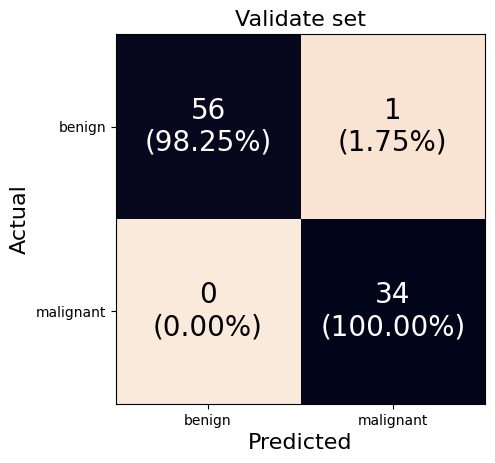

################# test set ##################
Best Threshold=0.508426
FPR: 0.0278
TPR: 0.9762
Confusion Matrix
----------------
[[70  2]
 [ 1 41]] 

----------------
1
Sensitivity: 97.62%
Specificity: 97.22%
Accuracy: 97.37%
Precision: 95.35%
Sensitivity: 97.62%
Precision: 95.35%
F1: 96.47%


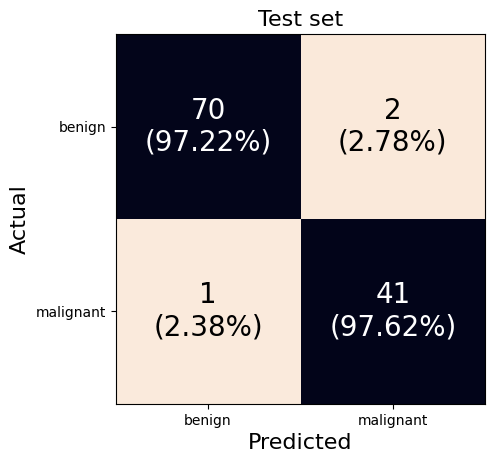

---------------------------------------
AUC validate: 99.85%
AUC test: 98.48%


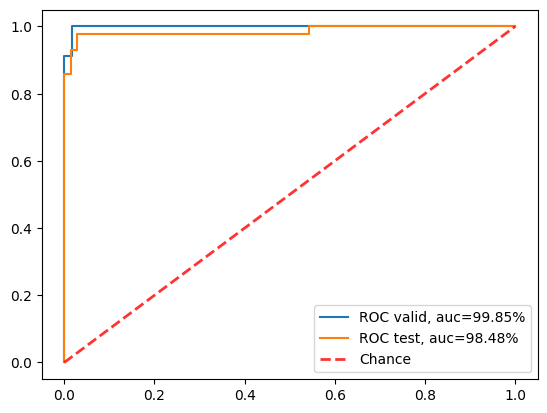

In [29]:
split = 1
param = 3
param1_split1_cm_val, param1_split1_cm_test, param1_split1_AUC_val, param1_split1_AUC_test = evaluate(param,split)

In [ ]:
model_path = "../logisticregression/models/param2/lr_model_{}.pkl".format(split)
loaded_model = joblib.load(model_path)
param2_split1_cm_val, param2_split1_cm_test, param2_split1_AUC_val, param2_split1_AUC_test = evaluate(param,split)

In [ ]:
param = 3
param3_split1_cm_val, param3_split1_cm_test, param3_split1_AUC_val, param3_split1_AUC_test = evaluate(param,split)

In [ ]:
# setting split and path
split = 'split1'
path = "../kitt/DATA_progress3/"
train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val.csv".format(path,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

In [ ]:
# grid search logistic regression model

# define model
#model = LogisticRegression()

# define parameter range
#param_grid = {'solver' : ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
#              'penalty' : ['l2'],
#              'C' : np.logspace(-4, 4, 50),
#              'max_iter' : [1000, 2000, 3000, 4000, 5000]}

# define search
#search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, error_score='raise', cv=5)

# execute search
#result = search.fit(x_train, y_train)

# summarize result
#print('Best Score: %s' % result.best_score_)
#print('Best Hyperparameters: %s' % result.best_params_)

In [ ]:
# create the individual models
model = LogisticRegression(C=109.85411419875572, max_iter=1000, penalty='l2', solver='lbfgs')
model.fit(x_train, y_train)

model_path = "../logisticregression/models/param1/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

In [ ]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split1 = sensitivity(cm_val)
spec_val_split1 = specificity(cm_val)
acc_val_split1 = accuracy(cm_val)
pre_val_split1 = precision(cm_val)
f1_val_split1 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split1 = sensitivity(cm_test)
spec_test_split1 = specificity(cm_test)
acc_test_split1 = accuracy(cm_test)
pre_test_split1 = precision(cm_test)
f1_test_split1 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split1 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split1 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split1)
print("AUC test: %.4f" % auc_test_split1)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split1))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split1))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split2

In [ ]:
# setting split and path
split = 'split2'
path = "../kitt/DATA_progress3/"
train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val.csv".format(path,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param1/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

In [ ]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split2 = sensitivity(cm_val)
spec_val_split2 = specificity(cm_val)
acc_val_split2 = accuracy(cm_val)
pre_val_split2 = precision(cm_val)
f1_val_split2 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split2 = sensitivity(cm_test)
spec_test_split2 = specificity(cm_test)
acc_test_split2 = accuracy(cm_test)
pre_test_split2 = precision(cm_test)
f1_test_split2 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split2 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split2 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split2)
print("AUC test: %.4f" % auc_test_split2)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split2))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split2))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split3

In [ ]:
# setting split and path
split = 'split3'
path = "../kitt/DATA_progress3/"
train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val.csv".format(path,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param1/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

In [ ]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split3 = sensitivity(cm_val)
spec_val_split3 = specificity(cm_val)
acc_val_split3 = accuracy(cm_val)
pre_val_split3 = precision(cm_val)
f1_val_split3 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split3 = sensitivity(cm_test)
spec_test_split3 = specificity(cm_test)
acc_test_split3 = accuracy(cm_test)
pre_test_split3 = precision(cm_test)
f1_test_split3 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split3 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split3 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split3)
print("AUC test: %.4f" % auc_test_split3)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split3))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split3))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split4

In [ ]:
# setting split and path
split = 'split4'
path = "../kitt/DATA_progress3/"
train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val.csv".format(path,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param1/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

In [ ]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split4 = sensitivity(cm_val)
spec_val_split4 = specificity(cm_val)
acc_val_split4 = accuracy(cm_val)
pre_val_split4 = precision(cm_val)
f1_val_split4 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split4 = sensitivity(cm_test)
spec_test_split4 = specificity(cm_test)
acc_test_split4 = accuracy(cm_test)
pre_test_split4 = precision(cm_test)
f1_test_split4 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split4 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split4 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split4)
print("AUC test: %.4f" % auc_test_split4)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split4))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split4))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split5

In [ ]:
# setting split and path
split = 'split5'
path = "../kitt/DATA_progress3/"
train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val.csv".format(path,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param1/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

In [ ]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split5 = sensitivity(cm_val)
spec_val_split5 = specificity(cm_val)
acc_val_split5 = accuracy(cm_val)
pre_val_split5 = precision(cm_val)
f1_val_split5 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split5 = sensitivity(cm_test)
spec_test_split5 = specificity(cm_test)
acc_test_split5 = accuracy(cm_test)
pre_test_split5 = precision(cm_test)
f1_test_split5 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split5 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split5 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split5)
print("AUC test: %.4f" % auc_test_split5)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split5))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split5))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

overall

In [ ]:
sensitivity_values = []

sensitivity_values.append(sen_val_split1)
sensitivity_values.append(sen_val_split2)
sensitivity_values.append(sen_val_split3)
sensitivity_values.append(sen_val_split4)
sensitivity_values.append(sen_val_split5)

print(sensitivity_values)

# calculating the mean of sample set
mean_sensitivity = statistics.mean(sensitivity_values)
# Calculate standard deviation of sensitivity
sensitivity_sd = statistics.stdev(sensitivity_values)

print("Mean Sensitivity:", mean_sensitivity)
print("Sensitivity Standard Deviation:", sensitivity_sd)

# Print mean sensitivity with standard deviation
print("Overall Sensitivity: %.2f ± %.2f%%" % (mean_sensitivity, sensitivity_sd))

specificity_values = []

specificity_values.append(spec_val_split1)
specificity_values.append(spec_val_split2)
specificity_values.append(spec_val_split3)
specificity_values.append(spec_val_split4)
specificity_values.append(spec_val_split5)
    
print(specificity_values)

# calculating the mean of sample set
mean_specificity = statistics.mean(specificity_values)
# Calculate standard deviation of sensitivity
specificity_sd = statistics.stdev(specificity_values)

print("Mean Specificity:", mean_specificity)
print("Specificity Standard Deviation:", specificity_sd)

# Print mean specificity with standard deviation
print("Overall Specificity: %.2f ± %.2f%%" % (mean_specificity, specificity_sd))

accuracy_values = []

accuracy_values.append(acc_val_split1)
accuracy_values.append(acc_val_split2)
accuracy_values.append(acc_val_split3)
accuracy_values.append(acc_val_split4)
accuracy_values.append(acc_val_split5)
    
print(accuracy_values)

# calculating the mean of sample set
mean_accuracy = statistics.mean(accuracy_values)
# Calculate standard deviation of sensitivity
accuracy_sd = statistics.stdev(accuracy_values)

print("Mean accuracy:", mean_accuracy)
print("accuracy Standard Deviation:", accuracy_sd)

# Print mean accuracy with standard deviation
print("Overall accuracy: %.2f ± %.2f%%" % (mean_accuracy, accuracy_sd))

precision_values = []

precision_values.append(pre_val_split1)
precision_values.append(pre_val_split2)
precision_values.append(pre_val_split3)
precision_values.append(pre_val_split4)
precision_values.append(pre_val_split5)
    
print(precision_values)

# calculating the mean of sample set
mean_precision = statistics.mean(precision_values)
# Calculate standard deviation of sensitivity
precision_sd = statistics.stdev(precision_values)

print("Mean precision:", mean_precision)
print("precision Standard Deviation:", precision_sd)

# Print mean specificity with standard deviation
print("Overall precision: %.2f ± %.2f%%" % (mean_precision, precision_sd))

f1_values = []

f1_values.append(f1_val_split1)
f1_values.append(f1_val_split2)
f1_values.append(f1_val_split3)
f1_values.append(f1_val_split4)
f1_values.append(f1_val_split5)
    
print(f1_values)

# calculating the mean of sample set
mean_f1 = statistics.mean(f1_values)
# Calculate standard deviation of sensitivity
f1_sd = statistics.stdev(f1_values)

print("Mean f1:", mean_f1)
print("f1 Standard Deviation:", f1_sd)

# Print mean specificity with standard deviation
print("Overall f1: %.2f ± %.2f%%" % (mean_f1, f1_sd))

auc_values = []

auc_values.append(auc_val_split1)
auc_values.append(auc_val_split2)
auc_values.append(auc_val_split3)
auc_values.append(auc_val_split4)
auc_values.append(auc_val_split5)
    
print(auc_values)

# calculating the mean of sample set
mean_auc = statistics.mean(auc_values)
# Calculate standard deviation of sensitivity
auc_sd = statistics.stdev(auc_values)

print("Mean auc:", mean_auc)
print("auc Standard Deviation:", auc_sd)

# Print mean auc with standard deviation
print("Overall auc: %.2f ± %.2f%%" % (mean_auc * 100, auc_sd))

parameter2 split2

In [ ]:
# setting split and path
split = 'split2'
path = "../kitt/DATA_progress3/"
train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val.csv".format(path,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

In [ ]:
# grid search logistic regression model

# define model
#model = LogisticRegression()

# define parameter range
#param_grid = {'solver' : ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
#              'penalty' : ['l2'],
#              'C' : np.logspace(-4, 4, 50),
#              'max_iter' : [1000, 2000, 3000, 4000, 5000]}

# define search
#search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, error_score='raise', cv=5)

# execute search
#result = search.fit(x_train, y_train)

# summarize result
#print('Best Score: %s' % result.best_score_)
#print('Best Hyperparameters: %s' % result.best_params_)

In [ ]:
# create the individual models
model = LogisticRegression(C=494.1713361323828, max_iter=1000, penalty='l2', solver='lbfgs')
model.fit(x_train, y_train)

model_path = "../logisticregression/models/param2/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

In [ ]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split2 = sensitivity(cm_val)
spec_val_split2 = specificity(cm_val)
acc_val_split2 = accuracy(cm_val)
pre_val_split2 = precision(cm_val)
f1_val_split2 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split2 = sensitivity(cm_test)
spec_test_split2 = specificity(cm_test)
acc_test_split2 = accuracy(cm_test)
pre_test_split2 = precision(cm_test)
f1_test_split2 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split2 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split2 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split2)
print("AUC test: %.4f" % auc_test_split2)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split2))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split2))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split1

In [ ]:
# setting split and path
split = 'split1'
path = "../kitt/DATA_progress3/"
train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val.csv".format(path,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param2/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

In [ ]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split1 = sensitivity(cm_val)
spec_val_split1 = specificity(cm_val)
acc_val_split1 = accuracy(cm_val)
pre_val_split1 = precision(cm_val)
f1_val_split1 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split1 = sensitivity(cm_test)
spec_test_split1 = specificity(cm_test)
acc_test_split1 = accuracy(cm_test)
pre_test_split1 = precision(cm_test)
f1_test_split1 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split1 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split1 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split1)
print("AUC test: %.4f" % auc_test_split1)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split1))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split1))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split3

In [ ]:
# setting split and path
split = 'split3'
path = "../kitt/DATA_progress3/"
train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val.csv".format(path,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param2/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

In [ ]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split3 = sensitivity(cm_val)
spec_val_split3 = specificity(cm_val)
acc_val_split3 = accuracy(cm_val)
pre_val_split3 = precision(cm_val)
f1_val_split3 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split3 = sensitivity(cm_test)
spec_test_split3 = specificity(cm_test)
acc_test_split3 = accuracy(cm_test)
pre_test_split3 = precision(cm_test)
f1_test_split3 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split3 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split3 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split3)
print("AUC test: %.4f" % auc_test_split3)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split3))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split3))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split4

In [ ]:
# setting split and path
split = 'split4'
path = "../kitt/DATA_progress3/"
train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val.csv".format(path,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param2/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

In [ ]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split4 = sensitivity(cm_val)
spec_val_split4 = specificity(cm_val)
acc_val_split4 = accuracy(cm_val)
pre_val_split4 = precision(cm_val)
f1_val_split4 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split4 = sensitivity(cm_test)
spec_test_split4 = specificity(cm_test)
acc_test_split4 = accuracy(cm_test)
pre_test_split4 = precision(cm_test)
f1_test_split4 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split4 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split4 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split4)
print("AUC test: %.4f" % auc_test_split4)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split4))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split4))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split5

In [ ]:
# setting split and path
split = 'split5'
path = "../kitt/DATA_progress3/"
train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val.csv".format(path,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param2/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

In [ ]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split5 = sensitivity(cm_val)
spec_val_split5 = specificity(cm_val)
acc_val_split5 = accuracy(cm_val)
pre_val_split5 = precision(cm_val)
f1_val_split5 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split5 = sensitivity(cm_test)
spec_test_split5 = specificity(cm_test)
acc_test_split5 = accuracy(cm_test)
pre_test_split5 = precision(cm_test)
f1_test_split5 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split5 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split5 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split5)
print("AUC test: %.4f" % auc_test_split5)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split5))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split5))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

In [ ]:
def evaluate(param,split):
    loaded_model = joblib.load('lr_model_final/lr_param{}_{}.joblib'.format(param,split))
    ############## validate set ################
    print("############## validate set ################")
    y_pred_val = loaded_model.predict(x_val)

    # Confusion matrix
    cm_val = confusion_matrix(y_val, y_pred_val)
    print('Confusion Matrix')
    print('-'*16)
    print(cm_val,'\n')
    print('-'*16)

    # Calculate score
    print(split)
    sen_val = sensitivity(cm_val)
    spec_val = specificity(cm_val)
    acc_val = accuracy(cm_val)
    pre_val = precision(cm_val)
    f1_score_val = f1(cm_val)

    # plot confusion matrix
    # plot confusion matrix
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_val.shape[1]),
           yticks=np.arange(cm_norm_val.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title("Validate set", fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_val.max() / 2.
    for i in range(cm_norm_val.shape[0]):
        for j in range(cm_norm_val.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_val[i, j] > thresh else "black")
    # plt.savefig('rf_model/validate_cm_{}.png'.format(split))
    # plt.savefig('rf_model/validate_cm_best_param2_{}.png'.format(split))
    plt.show()
    # ################# test set ##################
    label = ['benign','malignant']
    print("################# test set ##################")
    y_pred_test = loaded_model.predict(x_test)
    # Print the predictions
    # print(y_pred)

    # Confusion matrix
    cm_test = confusion_matrix(y_test, y_pred_test)
    print('Confusion Matrix')
    print('-'*16)
    print(cm_test,'\n')
    print('-'*16)

    # Calculate score
    print(split)
    sen_test = sensitivity(cm_test)
    spec_test = specificity(cm_test)
    acc_test = accuracy(cm_test)
    pre_test = precision(cm_test)
    f1_score_test = f1(cm_test)

    # plot confusion matrix
    # plot confusion matrix
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_test.shape[1]),
           yticks=np.arange(cm_norm_test.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title("Test set", fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_test.max() / 2.
    for i in range(cm_norm_test.shape[0]):
        for j in range(cm_norm_test.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_test[i, j] > thresh else "black")

    plt.show()

    ################## plot ROC curve ########################
    fpr1, tpr1, thr1 = roc_curve(y_val,  y_pred_val)
    auc1 = roc_auc_score(y_val,  y_pred_val)
    fpr2, tpr2, thr2 = roc_curve(y_test,  y_pred_test)
    auc2 = roc_auc_score(y_test,  y_pred_test)
    gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC validate: %.4f" % auc1)
    print("AUC test: %.4f" % auc2)
    plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc1))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc2))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()
    return cm_val,cm_test,auc1,auc2

In [ ]:
# setting split and path final test
path = "../kitt/DATA_progress3/"
train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
test_path =  "{}/test.csv".format(path)

path = "../Anny_oversampling/DATA/"
train_path = "{}/train.csv".format(path)
test_path =  "{}/test.csv".format(path)
print(train_path)
# Load the train set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)
print(test_path)
# Load the test set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)
# StandardScaler
sc = StandardScaler()
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

overall

In [ ]:
test_split1 = np.array([[51, 1], [2, 37]])
test_split2 = np.array([[52, 1], [3, 35]])
test_split3 = np.array([[66, 0], [1, 24]])
test_split4 = np.array([[71, 1], [0, 19]])
test_split5 = np.array([[67, 1], [0, 23]])

In [ ]:
overall_test = test_split1 + test_split2 + test_split3 + test_split4 + test_split5
print(overall_test)

In [ ]:
# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = overall_test.astype('float') / overall_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(overall_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

In [ ]:
sensitivity_values = []

sensitivity_values.append(sen_val_split1)
sensitivity_values.append(sen_val_split2)
sensitivity_values.append(sen_val_split3)
sensitivity_values.append(sen_val_split4)
sensitivity_values.append(sen_val_split5)

print(sensitivity_values)

# calculating the mean of sample set
mean_sensitivity = statistics.mean(sensitivity_values)
# Calculate standard deviation of sensitivity
sensitivity_sd = statistics.stdev(sensitivity_values)

print("Mean Sensitivity:", mean_sensitivity)
print("Sensitivity Standard Deviation:", sensitivity_sd)

# Print mean sensitivity with standard deviation
print("Overall Sensitivity: %.2f ± %.2f%%" % (mean_sensitivity, sensitivity_sd))

specificity_values = []

specificity_values.append(spec_val_split1)
specificity_values.append(spec_val_split2)
specificity_values.append(spec_val_split3)
specificity_values.append(spec_val_split4)
specificity_values.append(spec_val_split5)
    
print(specificity_values)

# calculating the mean of sample set
mean_specificity = statistics.mean(specificity_values)
# Calculate standard deviation of sensitivity
specificity_sd = statistics.stdev(specificity_values)

print("Mean Specificity:", mean_specificity)
print("Specificity Standard Deviation:", specificity_sd)

# Print mean specificity with standard deviation
print("Overall Specificity: %.2f ± %.2f%%" % (mean_specificity, specificity_sd))

accuracy_values = []

accuracy_values.append(acc_val_split1)
accuracy_values.append(acc_val_split2)
accuracy_values.append(acc_val_split3)
accuracy_values.append(acc_val_split4)
accuracy_values.append(acc_val_split5)
    
print(accuracy_values)

# calculating the mean of sample set
mean_accuracy = statistics.mean(accuracy_values)
# Calculate standard deviation of sensitivity
accuracy_sd = statistics.stdev(accuracy_values)

print("Mean accuracy:", mean_accuracy)
print("accuracy Standard Deviation:", accuracy_sd)

# Print mean accuracy with standard deviation
print("Overall accuracy: %.2f ± %.2f%%" % (mean_accuracy, accuracy_sd))

precision_values = []

precision_values.append(pre_val_split1)
precision_values.append(pre_val_split2)
precision_values.append(pre_val_split3)
precision_values.append(pre_val_split4)
precision_values.append(pre_val_split5)
    
print(precision_values)

# calculating the mean of sample set
mean_precision = statistics.mean(precision_values)
# Calculate standard deviation of sensitivity
precision_sd = statistics.stdev(precision_values)

print("Mean precision:", mean_precision)
print("precision Standard Deviation:", precision_sd)

# Print mean specificity with standard deviation
print("Overall precision: %.2f ± %.2f%%" % (mean_precision, precision_sd))

f1_values = []

f1_values.append(f1_val_split1)
f1_values.append(f1_val_split2)
f1_values.append(f1_val_split3)
f1_values.append(f1_val_split4)
f1_values.append(f1_val_split5)
    
print(f1_values)

# calculating the mean of sample set
mean_f1 = statistics.mean(f1_values)
# Calculate standard deviation of sensitivity
f1_sd = statistics.stdev(f1_values)

print("Mean f1:", mean_f1)
print("f1 Standard Deviation:", f1_sd)

# Print mean specificity with standard deviation
print("Overall f1: %.2f ± %.2f%%" % (mean_f1, f1_sd))

auc_values = []

auc_values.append(auc_val_split1)
auc_values.append(auc_val_split2)
auc_values.append(auc_val_split3)
auc_values.append(auc_val_split4)
auc_values.append(auc_val_split5)
    
print(auc_values)

# calculating the mean of sample set
mean_auc = statistics.mean(auc_values)
# Calculate standard deviation of sensitivity
auc_sd = statistics.stdev(auc_values)

print("Mean auc:", mean_auc)
print("auc Standard Deviation:", auc_sd)

# Print mean auc with standard deviation
print("Overall auc: %.2f ± %.2f%%" % (mean_auc * 100, auc_sd))

parameter3 split3

In [ ]:
# setting split and path
split = 'split3'
path = "../kitt/DATA_progress3/"
train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val.csv".format(path,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

In [ ]:
# grid search logistic regression model

# define model
#model = LogisticRegression()

# define parameter range
#param_grid = {'solver' : ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
#              'penalty' : ['l2'],
#              'C' : np.logspace(-4, 4, 50),
#              'max_iter' : [1000, 2000, 3000, 4000, 5000]}

# define search
#search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, error_score='raise', cv=5)

# execute search
#result = search.fit(x_train, y_train)

# summarize result
#print('Best Score: %s' % result.best_score_)
#print('Best Hyperparameters: %s' % result.best_params_)

In [ ]:
# create the individual models
model = LogisticRegression(C=2.559547922699533, max_iter=1000, penalty='l2', solver='lbfgs')
model.fit(x_train, y_train)

model_path = "../logisticregression/models/param3/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

In [ ]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split3 = sensitivity(cm_val)
spec_val_split3 = specificity(cm_val)
acc_val_split3 = accuracy(cm_val)
pre_val_split3 = precision(cm_val)
f1_val_split3 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split3 = sensitivity(cm_test)
spec_test_split3 = specificity(cm_test)
acc_test_split3 = accuracy(cm_test)
pre_test_split3 = precision(cm_test)
f1_test_split3 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split3 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split3 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split3)
print("AUC test: %.4f" % auc_test_split3)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split3))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split3))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split1

In [ ]:
# setting split and path
split = 'split1'
path = "../kitt/DATA_progress3/"
train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val.csv".format(path,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param3/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

In [ ]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split1 = sensitivity(cm_val)
spec_val_split1 = specificity(cm_val)
acc_val_split1 = accuracy(cm_val)
pre_val_split1 = precision(cm_val)
f1_val_split1 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split1 = sensitivity(cm_test)
spec_test_split1 = specificity(cm_test)
acc_test_split1 = accuracy(cm_test)
pre_test_split1 = precision(cm_test)
f1_test_split1 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split1 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split1 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split1)
print("AUC test: %.4f" % auc_test_split1)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split1))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split1))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split2

In [ ]:
# setting split and path
split = 'split2'
path = "../kitt/DATA_progress3/"
train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val.csv".format(path,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param3/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

In [ ]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split2 = sensitivity(cm_val)
spec_val_split2 = specificity(cm_val)
acc_val_split2 = accuracy(cm_val)
pre_val_split2 = precision(cm_val)
f1_val_split2 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split2 = sensitivity(cm_test)
spec_test_split2 = specificity(cm_test)
acc_test_split2 = accuracy(cm_test)
pre_test_split2 = precision(cm_test)
f1_test_split2 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split2 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split2 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split2)
print("AUC test: %.4f" % auc_test_split2)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split2))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split2))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split4

In [ ]:
# setting split and path
split = 'split4'
path = "../kitt/DATA_progress3/"
train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val.csv".format(path,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param3/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

In [ ]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split4 = sensitivity(cm_val)
spec_val_split4 = specificity(cm_val)
acc_val_split4 = accuracy(cm_val)
pre_val_split4 = precision(cm_val)
f1_val_split4 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split4 = sensitivity(cm_test)
spec_test_split4 = specificity(cm_test)
acc_test_split4 = accuracy(cm_test)
pre_test_split4 = precision(cm_test)
f1_test_split4 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split4 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split4 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split4)
print("AUC test: %.4f" % auc_test_split4)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split4))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split4))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split5

In [ ]:
# setting split and path
split = 'split5'
path = "../kitt/DATA_progress3/"
train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val.csv".format(path,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param3/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

In [ ]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split5 = sensitivity(cm_val)
spec_val_split5 = specificity(cm_val)
acc_val_split5 = accuracy(cm_val)
pre_val_split5 = precision(cm_val)
f1_val_split5 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split5 = sensitivity(cm_test)
spec_test_split5 = specificity(cm_test)
acc_test_split5 = accuracy(cm_test)
pre_test_split5 = precision(cm_test)
f1_test_split5 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split5 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split5 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split5)
print("AUC test: %.4f" % auc_test_split5)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split5))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split5))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

overall

In [ ]:
sensitivity_values = []

sensitivity_values.append(sen_val_split1)
sensitivity_values.append(sen_val_split2)
sensitivity_values.append(sen_val_split3)
sensitivity_values.append(sen_val_split4)
sensitivity_values.append(sen_val_split5)

print(sensitivity_values)

# calculating the mean of sample set
mean_sensitivity = statistics.mean(sensitivity_values)
# Calculate standard deviation of sensitivity
sensitivity_sd = statistics.stdev(sensitivity_values)

print("Mean Sensitivity:", mean_sensitivity)
print("Sensitivity Standard Deviation:", sensitivity_sd)

# Print mean sensitivity with standard deviation
print("Overall Sensitivity: %.2f ± %.2f%%" % (mean_sensitivity, sensitivity_sd))

specificity_values = []

specificity_values.append(spec_val_split1)
specificity_values.append(spec_val_split2)
specificity_values.append(spec_val_split3)
specificity_values.append(spec_val_split4)
specificity_values.append(spec_val_split5)
    
print(specificity_values)

# calculating the mean of sample set
mean_specificity = statistics.mean(specificity_values)
# Calculate standard deviation of sensitivity
specificity_sd = statistics.stdev(specificity_values)

print("Mean Specificity:", mean_specificity)
print("Specificity Standard Deviation:", specificity_sd)

# Print mean specificity with standard deviation
print("Overall Specificity: %.2f ± %.2f%%" % (mean_specificity, specificity_sd))

accuracy_values = []

accuracy_values.append(acc_val_split1)
accuracy_values.append(acc_val_split2)
accuracy_values.append(acc_val_split3)
accuracy_values.append(acc_val_split4)
accuracy_values.append(acc_val_split5)
    
print(accuracy_values)

# calculating the mean of sample set
mean_accuracy = statistics.mean(accuracy_values)
# Calculate standard deviation of sensitivity
accuracy_sd = statistics.stdev(accuracy_values)

print("Mean accuracy:", mean_accuracy)
print("accuracy Standard Deviation:", accuracy_sd)

# Print mean accuracy with standard deviation
print("Overall accuracy: %.2f ± %.2f%%" % (mean_accuracy, accuracy_sd))

precision_values = []

precision_values.append(pre_val_split1)
precision_values.append(pre_val_split2)
precision_values.append(pre_val_split3)
precision_values.append(pre_val_split4)
precision_values.append(pre_val_split5)
    
print(precision_values)

# calculating the mean of sample set
mean_precision = statistics.mean(precision_values)
# Calculate standard deviation of sensitivity
precision_sd = statistics.stdev(precision_values)

print("Mean precision:", mean_precision)
print("precision Standard Deviation:", precision_sd)

# Print mean specificity with standard deviation
print("Overall precision: %.2f ± %.2f%%" % (mean_precision, precision_sd))

f1_values = []

f1_values.append(f1_val_split1)
f1_values.append(f1_val_split2)
f1_values.append(f1_val_split3)
f1_values.append(f1_val_split4)
f1_values.append(f1_val_split5)
    
print(f1_values)

# calculating the mean of sample set
mean_f1 = statistics.mean(f1_values)
# Calculate standard deviation of sensitivity
f1_sd = statistics.stdev(f1_values)

print("Mean f1:", mean_f1)
print("f1 Standard Deviation:", f1_sd)

# Print mean specificity with standard deviation
print("Overall f1: %.2f ± %.2f%%" % (mean_f1, f1_sd))

auc_values = []

auc_values.append(auc_val_split1)
auc_values.append(auc_val_split2)
auc_values.append(auc_val_split3)
auc_values.append(auc_val_split4)
auc_values.append(auc_val_split5)
    
print(auc_values)

# calculating the mean of sample set
mean_auc = statistics.mean(auc_values)
# Calculate standard deviation of sensitivity
auc_sd = statistics.stdev(auc_values)

print("Mean auc:", mean_auc)
print("auc Standard Deviation:", auc_sd)

# Print mean auc with standard deviation
print("Overall auc: %.2f ± %.2f%%" % (mean_auc * 100, auc_sd))

parameter4 split4

In [ ]:
# setting split and path
split = 'split4'
path = "../kitt/DATA_progress3/"
train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val.csv".format(path,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

In [ ]:
# grid search logistic regression model

# define model
#model = LogisticRegression()

# define parameter range
#param_grid = {'solver' : ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
#              'penalty' : ['l2'],
#              'C' : np.logspace(-4, 4, 50),
#              'max_iter' : [1000, 2000, 3000, 4000, 5000]}

# define search
#search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, error_score='raise', cv=5)

# execute search
#result = search.fit(x_train, y_train)

# summarize result
#print('Best Score: %s' % result.best_score_)
#print('Best Hyperparameters: %s' % result.best_params_)

In [ ]:
# create the individual models
model = LogisticRegression(C=2222.996482526191, max_iter=1000, penalty='l2', solver='lbfgs')
model.fit(x_train, y_train)

model_path = "../logisticregression/models/param4/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

In [ ]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split4 = sensitivity(cm_val)
spec_val_split4 = specificity(cm_val)
acc_val_split4 = accuracy(cm_val)
pre_val_split4 = precision(cm_val)
f1_val_split4 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split4 = sensitivity(cm_test)
spec_test_split4 = specificity(cm_test)
acc_test_split4 = accuracy(cm_test)
pre_test_split4 = precision(cm_test)
f1_test_split4 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split4 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split4 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split4)
print("AUC test: %.4f" % auc_test_split4)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split4))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split4))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split1

In [ ]:
# setting split and path
split = 'split1'
path = "../kitt/DATA_progress3/"
train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val.csv".format(path,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param4/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

In [ ]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split1 = sensitivity(cm_val)
spec_val_split1 = specificity(cm_val)
acc_val_split1 = accuracy(cm_val)
pre_val_split1 = precision(cm_val)
f1_val_split1 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split1 = sensitivity(cm_test)
spec_test_split1 = specificity(cm_test)
acc_test_split1 = accuracy(cm_test)
pre_test_split1 = precision(cm_test)
f1_test_split1 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split1 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split1 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split1)
print("AUC test: %.4f" % auc_test_split1)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split1))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split1))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split2

In [ ]:
# setting split and path
split = 'split2'
path = "../kitt/DATA_progress3/"
train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val.csv".format(path,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param4/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

In [ ]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split2 = sensitivity(cm_val)
spec_val_split2 = specificity(cm_val)
acc_val_split2 = accuracy(cm_val)
pre_val_split2 = precision(cm_val)
f1_val_split2 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split2 = sensitivity(cm_test)
spec_test_split2 = specificity(cm_test)
acc_test_split2 = accuracy(cm_test)
pre_test_split2 = precision(cm_test)
f1_test_split2 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split2 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split2 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split2)
print("AUC test: %.4f" % auc_test_split2)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split2))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split2))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split3

In [ ]:
# setting split and path
split = 'split3'
path = "../kitt/DATA_progress3/"
train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val.csv".format(path,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param4/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

In [ ]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split3 = sensitivity(cm_val)
spec_val_split3 = specificity(cm_val)
acc_val_split3 = accuracy(cm_val)
pre_val_split3 = precision(cm_val)
f1_val_split3 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split3 = sensitivity(cm_test)
spec_test_split3 = specificity(cm_test)
acc_test_split3 = accuracy(cm_test)
pre_test_split3 = precision(cm_test)
f1_test_split3 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split3 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split3 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split3)
print("AUC test: %.4f" % auc_test_split3)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split3))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split3))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split5

In [ ]:
# setting split and path
split = 'split5'
path = "../kitt/DATA_progress3/"
train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val.csv".format(path,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param4/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

In [ ]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val_split5 = sensitivity(cm_val)
spec_val_split5 = specificity(cm_val)
acc_val_split5 = accuracy(cm_val)
pre_val_split5 = precision(cm_val)
f1_val_split5 = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split5 = sensitivity(cm_test)
spec_test_split5 = specificity(cm_test)
acc_test_split5 = accuracy(cm_test)
pre_test_split5 = precision(cm_test)
f1_test_split5 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val_split5 = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split5 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val_split5)
print("AUC test: %.4f" % auc_test_split5)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val_split5))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split5))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

overall

In [ ]:
sensitivity_values = []

sensitivity_values.append(sen_val_split1)
sensitivity_values.append(sen_val_split2)
sensitivity_values.append(sen_val_split3)
sensitivity_values.append(sen_val_split4)
sensitivity_values.append(sen_val_split5)

print(sensitivity_values)

# calculating the mean of sample set
mean_sensitivity = statistics.mean(sensitivity_values)
# Calculate standard deviation of sensitivity
sensitivity_sd = statistics.stdev(sensitivity_values)

print("Mean Sensitivity:", mean_sensitivity)
print("Sensitivity Standard Deviation:", sensitivity_sd)

# Print mean sensitivity with standard deviation
print("Overall Sensitivity: %.2f ± %.2f%%" % (mean_sensitivity, sensitivity_sd))

specificity_values = []

specificity_values.append(spec_val_split1)
specificity_values.append(spec_val_split2)
specificity_values.append(spec_val_split3)
specificity_values.append(spec_val_split4)
specificity_values.append(spec_val_split5)
    
print(specificity_values)

# calculating the mean of sample set
mean_specificity = statistics.mean(specificity_values)
# Calculate standard deviation of sensitivity
specificity_sd = statistics.stdev(specificity_values)

print("Mean Specificity:", mean_specificity)
print("Specificity Standard Deviation:", specificity_sd)

# Print mean specificity with standard deviation
print("Overall Specificity: %.2f ± %.2f%%" % (mean_specificity, specificity_sd))

accuracy_values = []

accuracy_values.append(acc_val_split1)
accuracy_values.append(acc_val_split2)
accuracy_values.append(acc_val_split3)
accuracy_values.append(acc_val_split4)
accuracy_values.append(acc_val_split5)
    
print(accuracy_values)

# calculating the mean of sample set
mean_accuracy = statistics.mean(accuracy_values)
# Calculate standard deviation of sensitivity
accuracy_sd = statistics.stdev(accuracy_values)

print("Mean accuracy:", mean_accuracy)
print("accuracy Standard Deviation:", accuracy_sd)

# Print mean accuracy with standard deviation
print("Overall accuracy: %.2f ± %.2f%%" % (mean_accuracy, accuracy_sd))

precision_values = []

precision_values.append(pre_val_split1)
precision_values.append(pre_val_split2)
precision_values.append(pre_val_split3)
precision_values.append(pre_val_split4)
precision_values.append(pre_val_split5)
    
print(precision_values)

# calculating the mean of sample set
mean_precision = statistics.mean(precision_values)
# Calculate standard deviation of sensitivity
precision_sd = statistics.stdev(precision_values)

print("Mean precision:", mean_precision)
print("precision Standard Deviation:", precision_sd)

# Print mean specificity with standard deviation
print("Overall precision: %.2f ± %.2f%%" % (mean_precision, precision_sd))

f1_values = []

f1_values.append(f1_val_split1)
f1_values.append(f1_val_split2)
f1_values.append(f1_val_split3)
f1_values.append(f1_val_split4)
f1_values.append(f1_val_split5)
    
print(f1_values)

# calculating the mean of sample set
mean_f1 = statistics.mean(f1_values)
# Calculate standard deviation of sensitivity
f1_sd = statistics.stdev(f1_values)

print("Mean f1:", mean_f1)
print("f1 Standard Deviation:", f1_sd)

# Print mean specificity with standard deviation
print("Overall f1: %.2f ± %.2f%%" % (mean_f1, f1_sd))

auc_values = []

auc_values.append(auc_val_split1)
auc_values.append(auc_val_split2)
auc_values.append(auc_val_split3)
auc_values.append(auc_val_split4)
auc_values.append(auc_val_split5)
    
print(auc_values)

# calculating the mean of sample set
mean_auc = statistics.mean(auc_values)
# Calculate standard deviation of sensitivity
auc_sd = statistics.stdev(auc_values)

print("Mean auc:", mean_auc)
print("auc Standard Deviation:", auc_sd)

# Print mean auc with standard deviation
print("Overall auc: %.2f ± %.2f%%" % (mean_auc * 100, auc_sd))

parameter5 split5

In [ ]:
# setting split and path
split = 'split5'
path = "../kitt/DATA_progress3/"
train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val.csv".format(path,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

In [ ]:
# grid search logistic regression model

# define model
#model = LogisticRegression()

# define parameter range
#param_grid = {'solver' : ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
#              'penalty' : ['l2'],
#              'C' : np.logspace(-4, 4, 50),
#              'max_iter' : [1000, 2000, 3000, 4000, 5000]}

# define search
#search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, error_score='raise', cv=5)

# execute search
#result = search.fit(x_train, y_train)

# summarize result
#print('Best Score: %s' % result.best_score_)
#print('Best Hyperparameters: %s' % result.best_params_)

In [ ]:
# create the individual models
model = LogisticRegression(C=1.7575106248547894, max_iter=1000, penalty='l2', solver='saga')
model.fit(x_train, y_train)

model_path = "../logisticregression/models/param5/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

In [ ]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split5 = sensitivity(cm_test)
spec_test_split5 = specificity(cm_test)
acc_test_split5 = accuracy(cm_test)
pre_test_split5 = precision(cm_test)
f1_test_split5 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split5 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split5)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split5))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split1

In [ ]:
# setting split and path
split = 'split1'
path = "../kitt/DATA_progress3/"
train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val.csv".format(path,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param5/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

In [ ]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split1 = sensitivity(cm_test)
spec_test_split1 = specificity(cm_test)
acc_test_split1 = accuracy(cm_test)
pre_test_split1 = precision(cm_test)
f1_test_split1 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split1 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split1)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split1))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split2

In [ ]:
# setting split and path
split = 'split2'
path = "../kitt/DATA_progress3/"
train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val.csv".format(path,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param5/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

In [ ]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split2 = sensitivity(cm_test)
spec_test_split2 = specificity(cm_test)
acc_test_split2 = accuracy(cm_test)
pre_test_split2 = precision(cm_test)
f1_test_split2 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split2 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split2)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split2))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split3

In [ ]:
# setting split and path
split = 'split3'
path = "../kitt/DATA_progress3/"
train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val.csv".format(path,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param5/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

In [ ]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split3 = sensitivity(cm_test)
spec_test_split3 = specificity(cm_test)
acc_test_split3 = accuracy(cm_test)
pre_test_split3 = precision(cm_test)
f1_test_split3 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split3 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split3)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split3))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split4

In [ ]:
# setting split and path
split = 'split4'
path = "../kitt/DATA_progress3/"
train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val.csv".format(path,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param5/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

In [ ]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')
    
def thresholding(y_val, y_pred_val):
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_val[:, 1])
    # get the best threshold
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))
    print('FPR: %.4f\nTPR: %.4f' %(fpr[ix], tpr[ix]))
    y_pred_val_new = to_labels(y_pred_val[:, 1], best_thresh)
    return y_pred_val_new

In [ ]:
def ROC_split(split1,split2,split3,split4,split5):
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val)
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val)*100
    
    fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test)
    auc2 = metrics.roc_auc_score(y_test,  y_pred_test)*100
    
    fpr3, tpr3, thr3 = metrics.roc_curve(y_test,  y_pred_test)
    auc3 = metrics.roc_auc_score(y_test,  y_pred_test)*100
    
    fpr4, tpr4, thr4 = metrics.roc_curve(y_test,  y_pred_test)
    auc4 = metrics.roc_auc_score(y_test,  y_pred_test)*100
    
    fpr5, tpr5, thr5 = metrics.roc_curve(y_test,  y_pred_test)
    auc5 = metrics.roc_auc_score(y_test,  y_pred_test)*100
    
    # gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    # ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC split1: %.2f%%" % auc1)
    print("AUC split2: %.2f%%" % auc2)
    print("AUC split3: %.2f%%" % auc1)
    print("AUC split4: %.2f%%" % auc2)
    print("AUC split5: %.2f%%" % auc1)
    
    plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.2f%%" % auc1))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc2))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc3))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc4))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc5))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()

In [ ]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val_raw = model.predict_proba(x_val)
y_pred_val = thresholding(y_val, y_pred_val_raw)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black", fontsize=20)
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test_raw = model.predict_proba(x_test)
y_pred_test = thresholding(y_test, y_pred_test_raw)

# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split4 = sensitivity(cm_test)
spec_test_split4 = specificity(cm_test)
acc_test_split4 = accuracy(cm_test)
pre_test_split4 = precision(cm_test)
f1_test_split4 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black", fontsize=20)
# Show plot
plt.show()

################## plot ROC curve ########################
pr1, tpr1, thr1 = roc_curve(y_val, y_pred_val_raw[:,1])
auc1 = roc_auc_score(y_val, y_pred_val_raw[:,1])*100
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test_raw[:,1])
auc2 = roc_auc_score(y_test, y_pred_test_raw[:,1])*100
gmeans2 = np.sqrt(tpr2 * (1-fpr2))
ix2 = np.argmax(gmeans2)
print("---------------------------------------")
print("AUC validate: %.2f%%" % auc1)
print("AUC test: %.2f%%" % auc2)
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.2f%%" % auc1))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc2))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

overall

In [ ]:
sensitivity_values = []

sensitivity_values.append(sen_val_split1)
sensitivity_values.append(sen_val_split2)
sensitivity_values.append(sen_val_split3)
sensitivity_values.append(sen_val_split4)
sensitivity_values.append(sen_val_split5)

print(sensitivity_values)

# calculating the mean of sample set
mean_sensitivity = statistics.mean(sensitivity_values)
# Calculate standard deviation of sensitivity
sensitivity_sd = statistics.stdev(sensitivity_values)

print("Mean Sensitivity:", mean_sensitivity)
print("Sensitivity Standard Deviation:", sensitivity_sd)

# Print mean sensitivity with standard deviation
print("Overall Sensitivity: %.2f ± %.2f%%" % (mean_sensitivity, sensitivity_sd))

specificity_values = []

specificity_values.append(spec_val_split1)
specificity_values.append(spec_val_split2)
specificity_values.append(spec_val_split3)
specificity_values.append(spec_val_split4)
specificity_values.append(spec_val_split5)
    
print(specificity_values)

# calculating the mean of sample set
mean_specificity = statistics.mean(specificity_values)
# Calculate standard deviation of sensitivity
specificity_sd = statistics.stdev(specificity_values)

print("Mean Specificity:", mean_specificity)
print("Specificity Standard Deviation:", specificity_sd)

# Print mean specificity with standard deviation
print("Overall Specificity: %.2f ± %.2f%%" % (mean_specificity, specificity_sd))

accuracy_values = []

accuracy_values.append(acc_val_split1)
accuracy_values.append(acc_val_split2)
accuracy_values.append(acc_val_split3)
accuracy_values.append(acc_val_split4)
accuracy_values.append(acc_val_split5)
    
print(accuracy_values)

# calculating the mean of sample set
mean_accuracy = statistics.mean(accuracy_values)
# Calculate standard deviation of sensitivity
accuracy_sd = statistics.stdev(accuracy_values)

print("Mean accuracy:", mean_accuracy)
print("accuracy Standard Deviation:", accuracy_sd)

# Print mean accuracy with standard deviation
print("Overall accuracy: %.2f ± %.2f%%" % (mean_accuracy, accuracy_sd))

precision_values = []

precision_values.append(pre_val_split1)
precision_values.append(pre_val_split2)
precision_values.append(pre_val_split3)
precision_values.append(pre_val_split4)
precision_values.append(pre_val_split5)
    
print(precision_values)

# calculating the mean of sample set
mean_precision = statistics.mean(precision_values)
# Calculate standard deviation of sensitivity
precision_sd = statistics.stdev(precision_values)

print("Mean precision:", mean_precision)
print("precision Standard Deviation:", precision_sd)

# Print mean specificity with standard deviation
print("Overall precision: %.2f ± %.2f%%" % (mean_precision, precision_sd))

f1_values = []

f1_values.append(f1_val_split1)
f1_values.append(f1_val_split2)
f1_values.append(f1_val_split3)
f1_values.append(f1_val_split4)
f1_values.append(f1_val_split5)
    
print(f1_values)

# calculating the mean of sample set
mean_f1 = statistics.mean(f1_values)
# Calculate standard deviation of sensitivity
f1_sd = statistics.stdev(f1_values)

print("Mean f1:", mean_f1)
print("f1 Standard Deviation:", f1_sd)

# Print mean specificity with standard deviation
print("Overall f1: %.2f ± %.2f%%" % (mean_f1, f1_sd))

auc_values = []

auc_values.append(auc_val_split1)
auc_values.append(auc_val_split2)
auc_values.append(auc_val_split3)
auc_values.append(auc_val_split4)
auc_values.append(auc_val_split5)
    
print(auc_values)

# calculating the mean of sample set
mean_auc = statistics.mean(auc_values)
# Calculate standard deviation of sensitivity
auc_sd = statistics.stdev(auc_values)

print("Mean auc:", mean_auc)
print("auc Standard Deviation:", auc_sd)

# Print mean auc with standard deviation
print("Overall auc: %.2f ± %.2f%%" % (mean_auc * 100, auc_sd))